<a href="https://colab.research.google.com/github/Kevin2558/Data_Science_Borrador/blob/main/07_Deep_Learning/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grad-CAM**

Técnica de visualización que permite entender que partes de una imagen influyeron más en la toma de decisiones de una red neuronal convolucional.

Grad-CAM genera un mapa de calor superpuesto a la imagen original, que muestra las regiones más importantes que contribuyeron a la predicción del modelo. Este mapa está basado en los gradientes que fluyen hacia las últimas capas convolucionales.

In [1]:
!pip -q install torch torchvision grad-cam pillow requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.8 MB/s e

In [2]:
!pip install -q --upgrade grad-cam

In [3]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt, torch, requests, io
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm

In [4]:
# Dataset

tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_ds = datasets.CIFAR10('data', train=True, download=True, transform=tfms)
test_ds = datasets.CIFAR10('data', train=False, transform=tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

100%|██████████| 170M/170M [00:19<00:00, 8.88MB/s]


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1),nn.BatchNorm2d(128),nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
    def forward(self,x): return self.classifier(self.features(x))

model = SimpleCNN().to(device)
print(f'Parámetros: {sum(p.numel() for p in model.parameters())}')

Parámetros: 620810


In [6]:
criterion = nn.CrossEntropyLoss() # Para clasificación multiple (incluye softmax)
# Optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), # Parámetros a optimizar
                             lr=1e-3, # Tasa de aprendizaje
                             weight_decay=1e-4 # Regularización L2
                             )

In [8]:
# Precisión
def accuracy(net, loader):
  net.eval(); correct = total = 0
  with torch.no_grad():
    for xb, yb in loader:
      pred = net(xb.to(device)).argmax(1).cpu()
      correct += (pred==yb).sum().item()
      total += yb.size(0)
  return correct/total

# Entrenamiento
epochs = 5
for ep in range(1,epochs+1):
  model.train()
  for xb, yb in tqdm(train_dl, desc=f'Epoch {ep}/{epochs}', leave=False):
    xb, yb = xb.to(device), yb.to(device)
    pred = model(xb)
    loss = criterion(pred, yb)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  val_acc = accuracy(model, test_dl)
  print(f'Época {ep:02d} | val acc: {val_acc*100:.2f}%')

# Guardar el modelo
torch.save(model, 'cnn_cifar10.pt')
print('Modelo guardado como cnn_cifar10.pt en el directorio de Colab')

Epoch 1/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 01 | val acc: 68.56%


Epoch 2/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 02 | val acc: 73.22%


Epoch 3/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 03 | val acc: 72.98%


Epoch 4/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 04 | val acc: 75.78%


Epoch 5/5:   0%|          | 0/1563 [00:00<?, ?it/s]

Época 05 | val acc: 77.79%
Modelo guardado como cnn_cifar10.pt en el directorio de Colab


In [9]:
torch.save(model.state_dict(), 'cnn_cifar10_sd.pt')

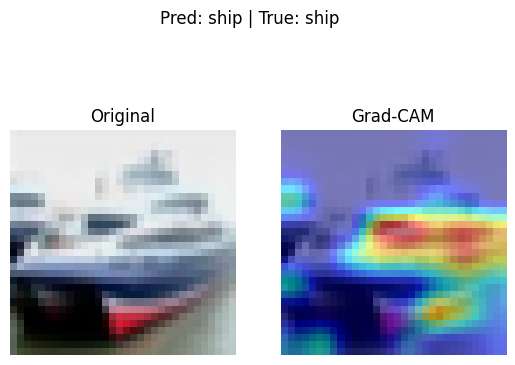

In [11]:
# Cargamos la CNN casera entrenada anteriormente
model = torch.load('cnn_cifar10.pt', map_location='cpu', weights_only=False).eval()

# Tomar un lote de prueba (del DataLoader que ya tenemos)
imgs, labels = next(iter(test_dl))
img, label = imgs[1:2], labels[1]

# Preparar Grad-CAM sobre la última conv de nuestra red
target_layer = model.features[-3]
img = img.to(device)

with GradCAM(model=model, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(input_tensor=img)[0]

# Des-normalizar para visualizar
def denorm(t):
  mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
  std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
  return torch.clamp(t*std+mean, 0, 1)

rgb = denorm(img.cpu()[0]).permute(1,2,0).numpy()
cam_img = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

classes = test_ds.classes
model.to(device).eval()
pred_idx = model(img.to(device)).argmax(1).item()
true_idk = label.item()
pred = model(img).argmax(1).item()

true = label.item()
title = f'Pred: {classes[pred]} | True: {classes[true]}'
plt.subplot(1,2,1); plt.imshow(rgb); plt.axis('off') ;plt.title('Original')
plt.subplot(1,2,2); plt.imshow(cam_img); plt.axis('off') ;plt.title('Grad-CAM')
plt.suptitle(title, fontsize=12)
plt.show()


Interpretación rápida:
* Las zonas rojas indican contribución postivca alta a la clase predicha
* Si la red acertó y el rojo cubre el objeto, aprendió el patrón correcto
* Si se enfoca en el fondo, indica posible sesgo, este sería un buen punto de partida para el transfer learning